# **K Vecinos Más Cercanos (K Nearest Neighbor)**

En este laboratorio, aprenderás y practicarás el modelo de K Vecinos Más Cercanos (KNN). KNN es un modelo sencillo pero muy efectivo que se puede usar tanto para tareas de clasificación como de regresión. Si el espacio de características no es muy grande, KNN puede ser un modelo altamente interpretable porque puedes explicar y entender cómo se hace una predicción al observar a sus vecinos más cercanos.

Usaremos un conjunto de datos de muestras de tumores que contiene los resultados de pruebas de laboratorio sobre muestras de tumores. El objetivo es clasificar si un tumor es maligno (cáncer) o benigno. Por lo tanto, es una tarea de clasificación binaria típica.

## Objetivos

Después de completar este laboratorio, serás capaz de:

* Entrenar modelos KNN con diferentes hiperparámetros de vecinos
* Evaluar modelos KNN en tareas de clasificación
* Ajustar el número de vecinos y encontrar el óptimo para una tarea específica

Primero, instalemos `seaborn` para las tareas de visualización e importemos las bibliotecas necesarias para este laboratorio.

In [1]:
# Todas las bibliotecas necesarias para este laboratorio están listadas a continuación. Las bibliotecas preinstaladas en Skills Network Labs están comentadas.

# !mamba install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0

# ¡Nota: Si tu entorno no admite "!mamba install", usa "!pip install".


In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
# Métodos relacionados con las métricas de evaluación
from sklearn.metrics import classification_report, accuracy_score,f1_score, confusion_matrix, precision_recall_fscore_support,precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# Define una semilla aleatoria para reproducir cualquier proceso aleatorio
rs= 123

In [43]:
# # Ignorar cualquier advertencia de desaprobación
# import warnings
# warnings.filterwarnings('ignore', category=DeprecationWarning)

## Cargar y explorar el conjunto de datos de muestras de tumores

Primero cargamos el conjunto de datos `tumor.csv` como un dataframe de Pandas:

In [5]:
# Leer el conjunto de datos en formato csv
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/tumor.csv"
tumor_df = pd.read_csv(dataset_url)

Luego, echemos un vistazo rápido a las primeras filas del dataframe.

In [6]:
tumor_df.head()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


Y, mostramos sus columnas.

In [7]:
tumor_df.columns

Index(['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc',
       'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

Cada observación en este conjunto de datos contiene resultados de pruebas de laboratorio sobre una muestra de tumor, como cúmulos o formas. Basándonos en estos resultados de laboratorio o características, queremos construir un modelo de clasificación para predecir si esta muestra de tumor es maligna (cáncer) o benigna. La variable objetivo `y` se especifica en la columna `Class`.

Entonces, dividamos el conjunto de datos en entradas `X` y salida `y`:

In [9]:
X = tumor_df.iloc[:, :-1]
y = tumor_df.iloc[:,-1:]

Y primero revisamos el resumen estadístico de las características en X:

In [10]:
X.describe()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


Como podemos ver en la salida de la celda anterior, todas las características son numéricas y varían entre 1 y 10. Esto es muy conveniente ya que no necesitamos escalar los valores de las características, pues ya están en el mismo rango.

A continuación, revisemos la distribución de clases del output `y`:

In [11]:
y.value_counts(normalize=True)

Class
0        0.650073
1        0.349927
Name: proportion, dtype: float64

<Axes: xlabel='Class'>

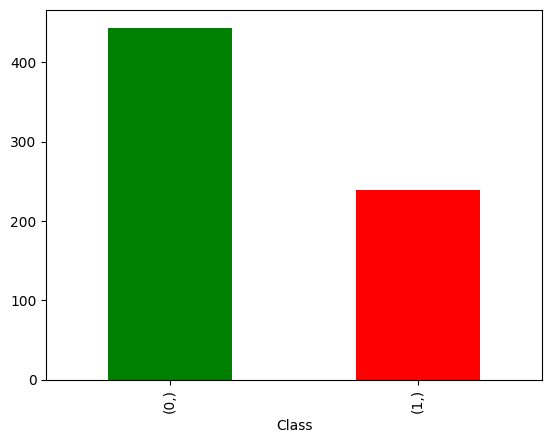

In [12]:
y.value_counts().plot.bar(color=['green', 'red'])

Tenemos aproximadamente un 65% de tumores benignos (`Class = 0`) y un 35% de tumores cancerosos (`Class = 1`), lo cual no representa una distribución de clases muy desbalanceada.

## Dividir los conjuntos de datos de entrenamiento y prueba

In [13]:
# Dividir el 80% como conjunto de datos de entrenamiento
# y el 20% como conjunto de datos de prueba
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.2, stratify=y,random_state=rs)

## Entrenar y evaluar un clasificador KNN con el número de vecinos establecido en 2

Entrenar un clasificador KNN es muy similar a entrenar otros clasificadores en `sklearn`, primero necesitamos definir un objeto `KNeighborsClassifier`. Aquí usamos el argumento `n_neighbors=2` para especificar cuántos vecinos se usarán para la predicción, y mantenemos otros argumentos en sus valores predeterminados.

In [14]:
# Define a KNN classifier with `n_neighbors=2`
knn_model = KNeighborsClassifier(n_neighbors=2)

Luego podemos entrenar el modelo con `X_train` y `y_train`, y usamos el método `ravel()` para convertir el marco de datos `y_train` en un vector.

In [15]:
knn_model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

Y podemos hacer predicciones sobre el dataframe `X_test`.

In [16]:
preds = knn_model.predict(X_test)

Para evaluar el clasificador KNN, proporcionamos un método predefinido que devuelve las métricas de evaluación comúnmente usadas, como precisión (accuracy), recall, precisión (precision), f1score, y otras, basadas en las clases verdaderas en el 'y_test' y las predicciones del modelo.

In [17]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision,recall,f_beta, _= precision_recall_fscore_support(yt,yp, average='binary')
    results_pos['recall']= recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [18]:
evaluate_metrics(y_test, preds)

{'accuracy': 0.9416058394160584,
 'recall': 0.875,
 'precision': 0.9545454545454546,
 'f1score': 0.9130434782608695}

Podemos ver que hay un gran rendimiento de clasificación en el conjunto de datos de muestras de tumores. Esto significa que el modelo KNN puede reconocer eficazmente los tumores cancerosos.
A continuación, es tu turno de probar con un número diferente de vecinos para ver si podemos obtener un rendimiento aún mejor.

## Ejercicio de codificación: Entrenar y evaluar un clasificador KNN con el número de vecinos establecido en 5

Primero, define un clasificador KNN con la clase KNeighborsClassifier:

In [19]:
knn_model = KNeighborsClassifier(n_neighbors=5)

Luego, entrena el modelo con X_train y y_train:

In [20]:
knn_model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier()

Y haz predicciones sobre el dataframe X_test:

In [22]:
preds = knn_model.predict(X_test)
evaluate_metrics(y_test, preds)

{'accuracy': 0.9781021897810219,
 'recall': 0.9791666666666666,
 'precision': 0.9591836734693877,
 'f1score': 0.9690721649484536}

Y haz predicciones sobre el dataframe X_test:

<details><summary>Click here for a sample solution</summary>

```python
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train.values.ravel())
preds = model.predict(X_test)
evaluate_metrics(y_test, preds)
```

</details>

## Ajustar el número de vecinos para encontrar el óptimo

OK, es posible que te preguntes qué argumento `n_neighbors` puede darte el mejor rendimiento de clasificación. Podemos probar diferentes valores de `n_neighbors` (el valor de K) y verificar cuál `K` ofrece el mejor rendimiento de clasificación.

Luego entrenaremos 50 clasificadores KNN con K que varía de 1 a 50.

In [47]:
# Probar K desde 1 hasta 50
max_k = 50
# Crear una lista vacía para almacenar el f1score para cada k
f1_scores = []

for k in range(1, max_k + 1):
    # Crear un clasificador KNN
    knn = KNeighborsClassifier(n_neighbors=k)
    # Entrenar el clasificador
    knn.fit(X_train, y_train.values.ravel())
    preds = knn.predict(X_test)
    # Evaluar el clasificador con f1score
    f1 = f1_score(y_test, preds)
    f1_scores.append((k, round(f1, 4)))

# Convertir la lista de f1score a un dataframe
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
f1_results.set_index('K', inplace=True)

f1_results


,F1 Score
K,
1,0.9485
2,0.9130
3,0.9485
4,0.9583
5,0.9691
6,0.9583
7,0.9583
8,0.9474
9,0.9474


Esta es una lista larga y difícil de analizar, así que visualicemos la lista usando un gráfico de líneas.


Text(0.5, 1.0, 'KNN F1 Score')

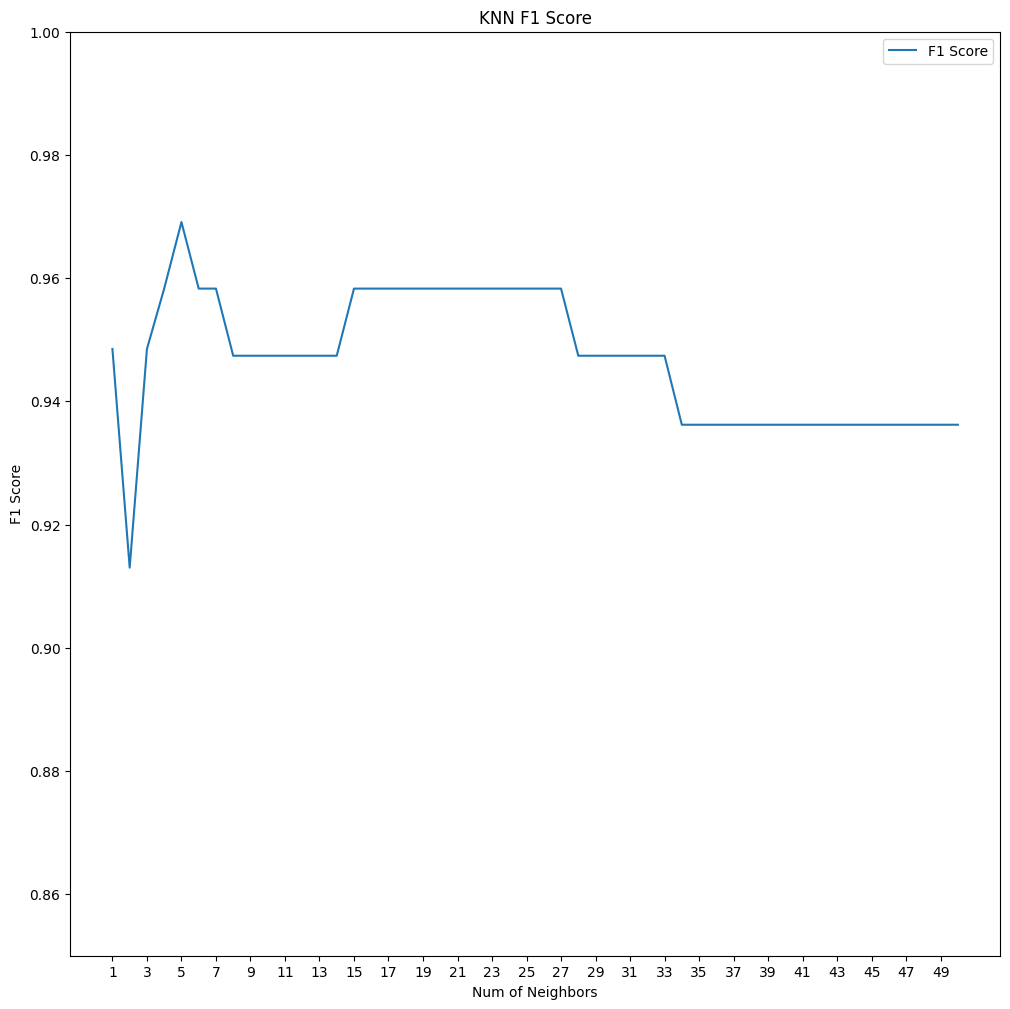

In [48]:
# Graficar los resultados de F1
ax = f1_results.plot(figsize=(12, 12))
ax.set(xlabel='Num of Neighbors', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.ylim((0.85, 1))
plt.title('KNN F1 Score')

Como podemos ver en el gráfico de la línea de puntuación F1, el mejor valor de `K` es 5 con una puntuación F1 de aproximadamente `0.9691`.

## Próximos pasos
¡Genial! Ahora has aprendido sobre el modelo KNN y lo has aplicado para resolver un problema de clasificación de tipos de tumores del mundo real. También ajustaste KNN para encontrar el mejor valor de K. Más adelante, continuarás aprendiendo sobre otros modelos de clasificación populares con diferentes estructuras, suposiciones, funciones de costo y escenarios de aplicación.